In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset


import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset , TimeSeriesTestDataset
from ddpm_Time_Series_copy import TCN 
from ddpm_Time_Series_copy import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding

#===========================

# Model training 

In [13]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/UCR/DISTORTEDWalkingAceleration1",
  "output_dir": "output",
  "train_batch_size": 4,
  "eval_batch_size": 4,
  "num_epochs": 30,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1000,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.002,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)

In [4]:
from noise_scheduler import PinkNoiseScheduler

Training model...


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.172, step=29]

eval timesteps tensor([192, 629, 848, 444])


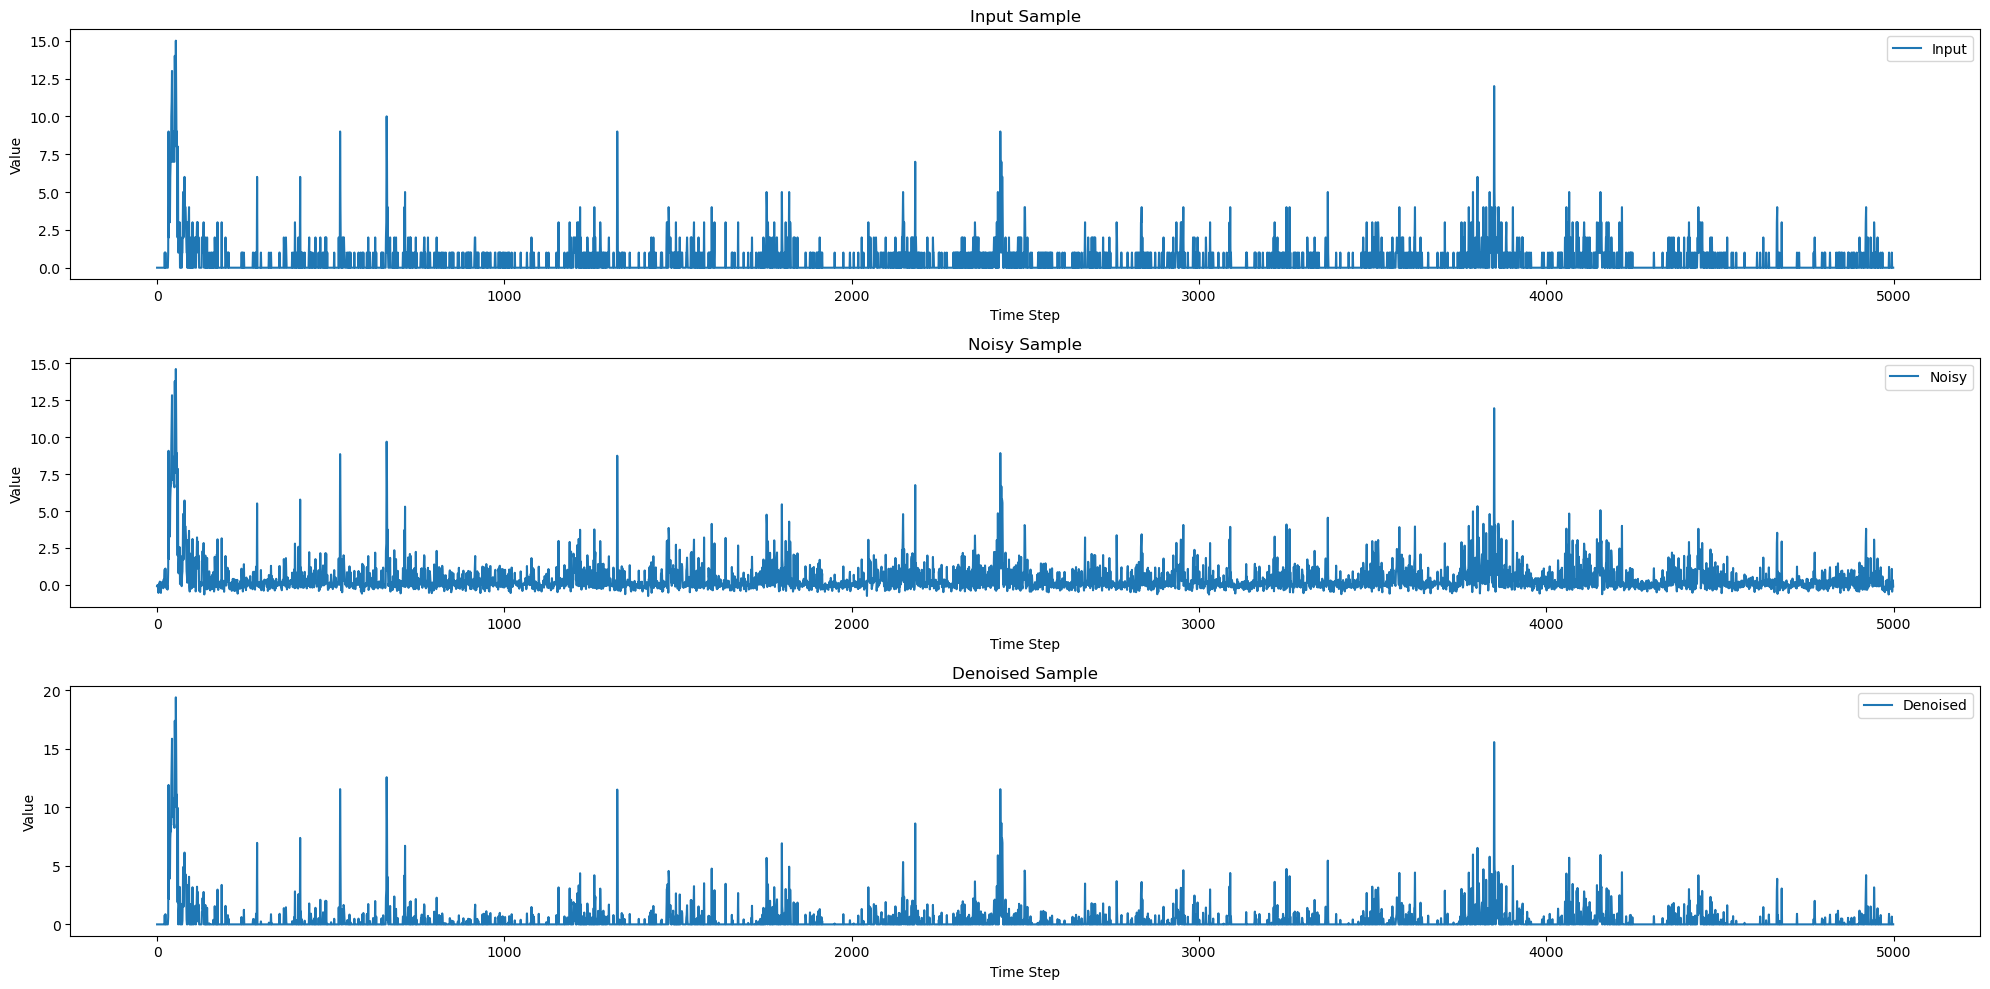

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s, loss=0.172, step=29]


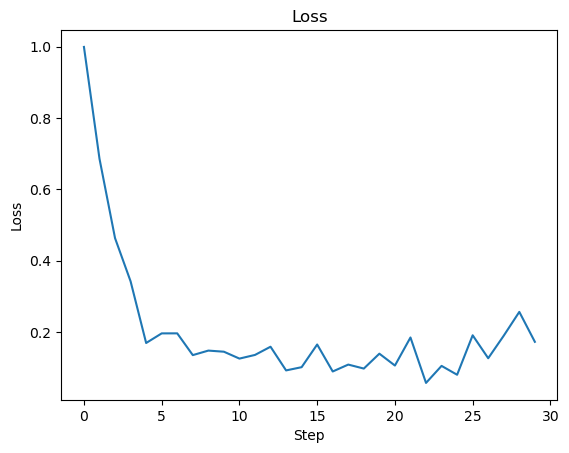

Model saved at output/30/model.pth
Losses saved at output/30/losses.json
Config saved at output/30/config.json


<Figure size 640x480 with 0 Axes>

In [14]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn


# Continue with the rest of your training loop...

sequence_length = 5000
input_size = 1  # Assuming 1D time series data


# Assuming you have the rest of your code defined already...

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)


# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=1000, stride=100,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=1000, stride=100, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

#================================================================================================

noise_scheduler = PinkNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.
      
for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(dataloader):
        '''if model.input_shape == 'NCL':
            batch = batch.unsqueeze(1)  # Add channel dimension: (batch_size, 1, sequence_length)'''
        #elif model.input_shape == 'NLC':
            #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        #noise = torch.randn_like(batch)
        
        # timesteps from o to num_timesteps
        #timesteps = torch.arange(0, noise_scheduler.num_timesteps).repeat(batch.shape[0], 1)
        
        #timesteps = torch.linspace(0, noise_scheduler.num_timesteps - 1, steps=batch.shape[0]).long()
        std_data = torch.std(batch)

        # I want the noise level increasing with epoch
        noise_level = 0.1 * (epoch+10)/5
        noise = torch.randn_like(batch) * std_data * noise_level
                
        #noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        #print("timesteps", timesteps)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noisy = noisy.unsqueeze(-1) 
        # pred noise from the model
        noise_pred = model(noisy)
        
        #print("noise_pred", noise_pred.shape)
        batch = batch.unsqueeze(-1)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(sample)
                noise_level = 0.1
                noise = torch.randn_like(sample) #* std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()
    
    
# save the model, losses and all the config parameters in a directory 
import os
import json

# output dir contains the num epochs 
output_dir = os.path.join(config.output_dir, str(config.num_epochs))
# create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True) 

# Save the model
model_path = os.path.join(output_dir, "model.pth")
torch.save(model.state_dict(), model_path)

# Save the losses and the lother parameters in a json file 
losses_path = os.path.join(output_dir, "losses.json")
with open(losses_path, "w") as f:
    json.dump(losses, f)
    
# Save the config 
config_path = os.path.join(output_dir, "config.json")
with open(config_path, "w") as f:
    json.dump(vars(config), f)

# save the losses plot
# plot the loss
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()
losses_plot_path = os.path.join(output_dir, "losses_plot.png")
plt.savefig(losses_plot_path)
    
print("Model saved at", model_path)
print("Losses saved at", losses_path)
print("Config saved at", config_path)



# Evaluation and anomaly prediction one sample 

In [6]:
# import f1 score and auprc score for 0/1 classification

from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score

# define the function to calculate the f1 score and auprc score
def calculate_f1_auprc_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred) 
    recall = recall_score(y_true, y_pred)
    return f1, auprc, precision, recall


  0%|          | 0/1 [00:00<?, ?it/s]

eval timesteps tensor([694, 855, 419, 828])


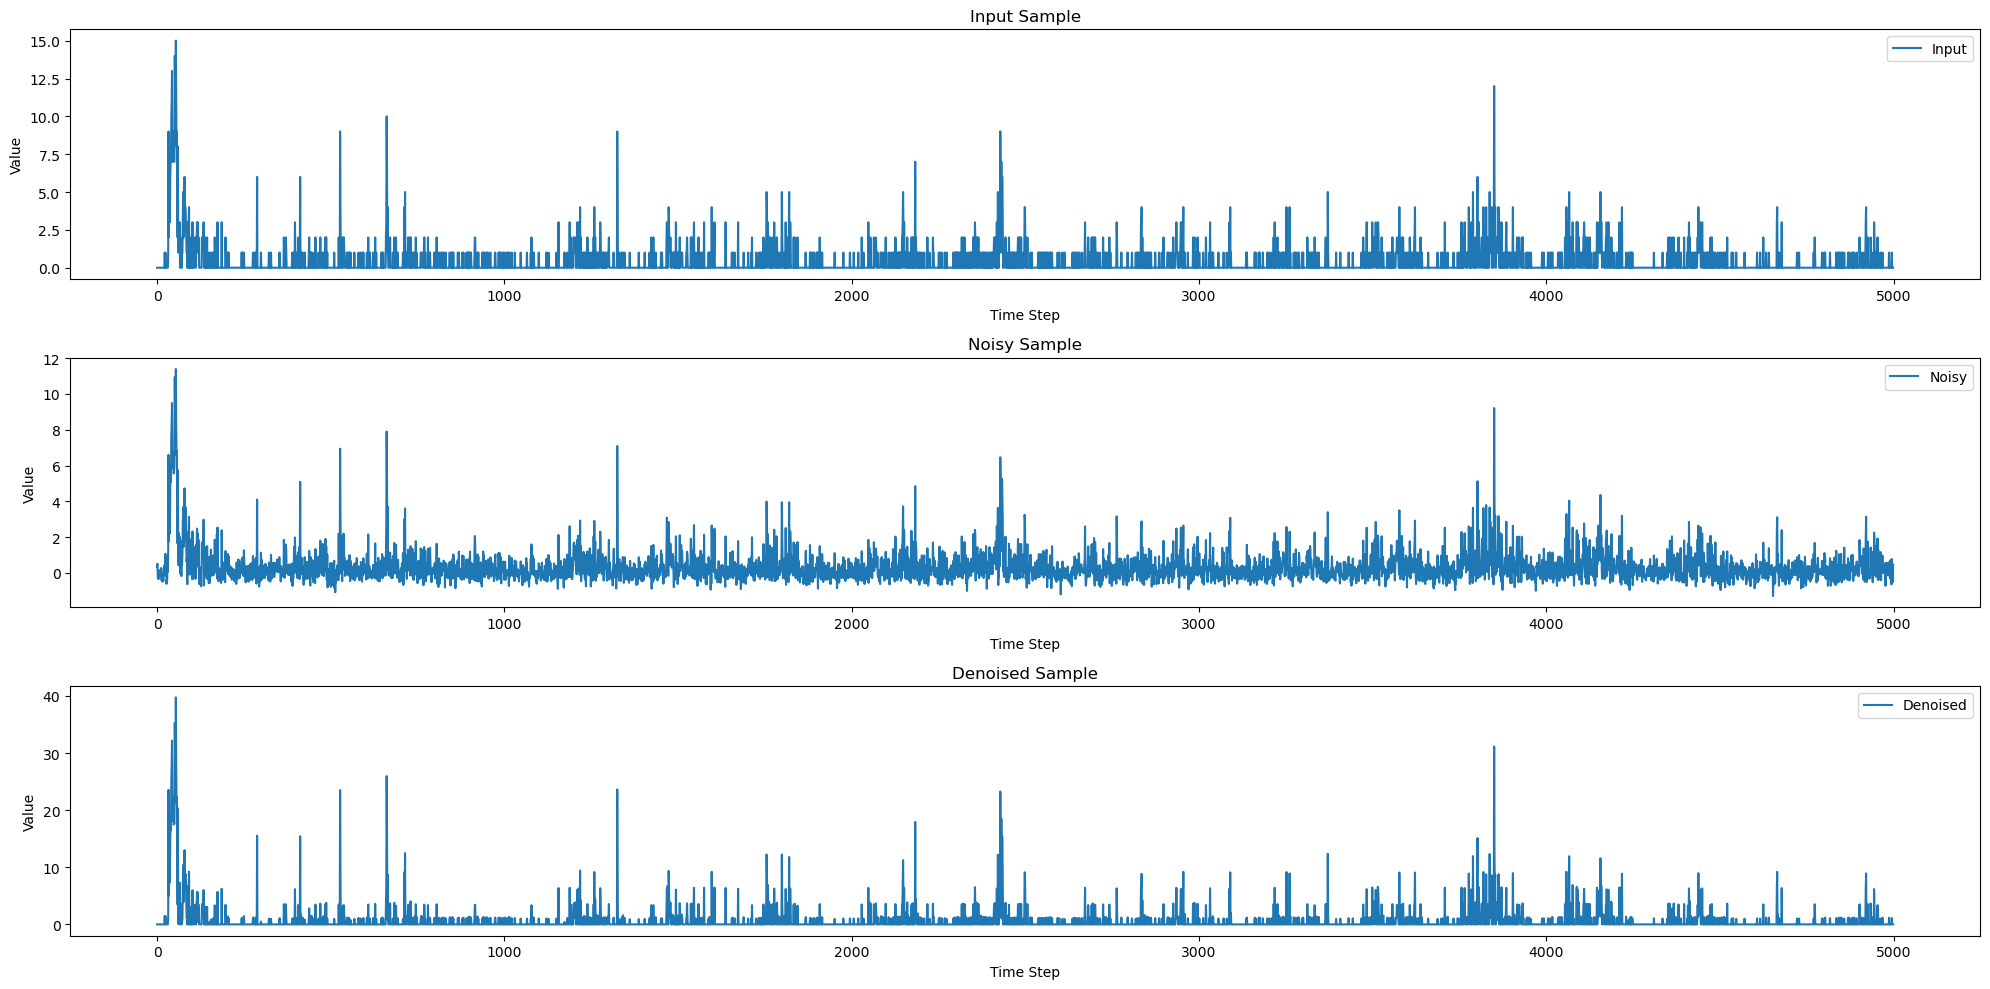

std_data tensor(1.1039)
Outliers: [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]
labels tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
Precision score: 0.2554347826086957
Recall score: 0.1902834008097166
F1 score: 0.21809744779582366
AUPRC score: 0.08860499911987327
Results saved at output/30/results.json


<Figure size 640x480 with 0 Axes>

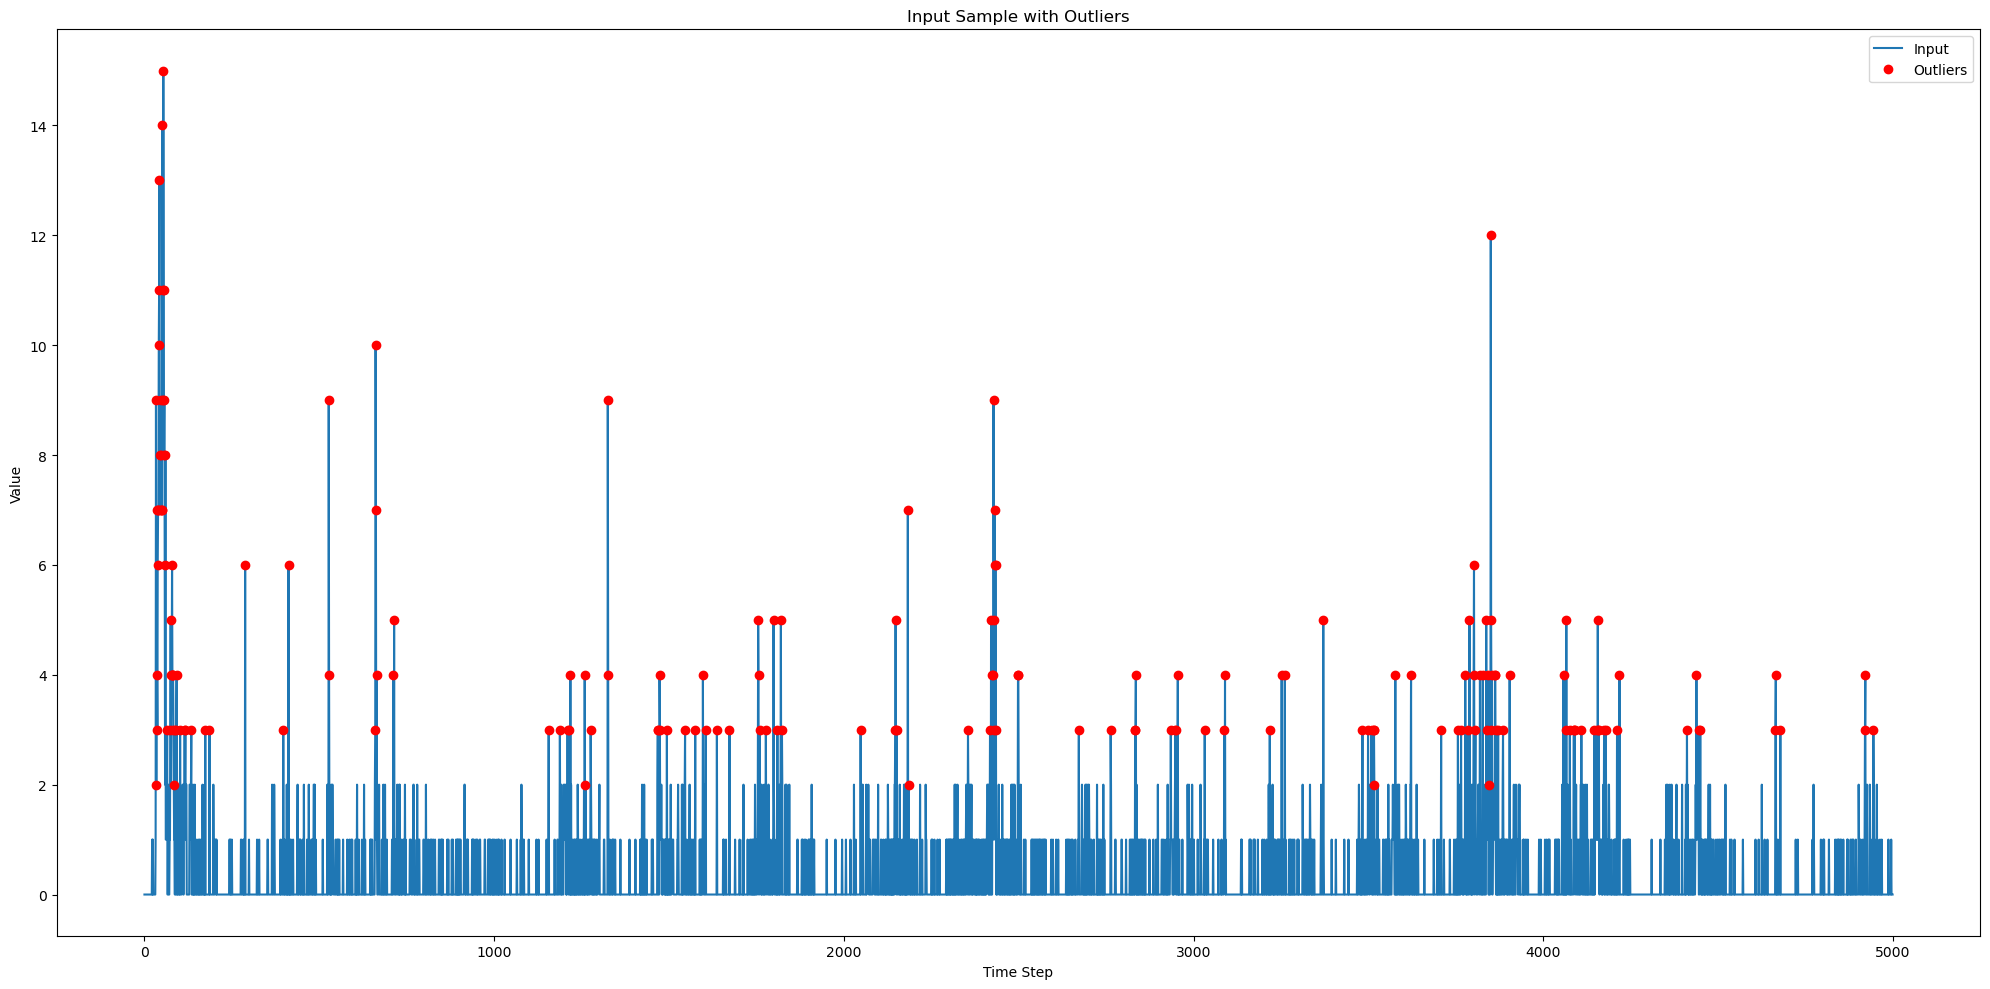

<Figure size 640x480 with 0 Axes>

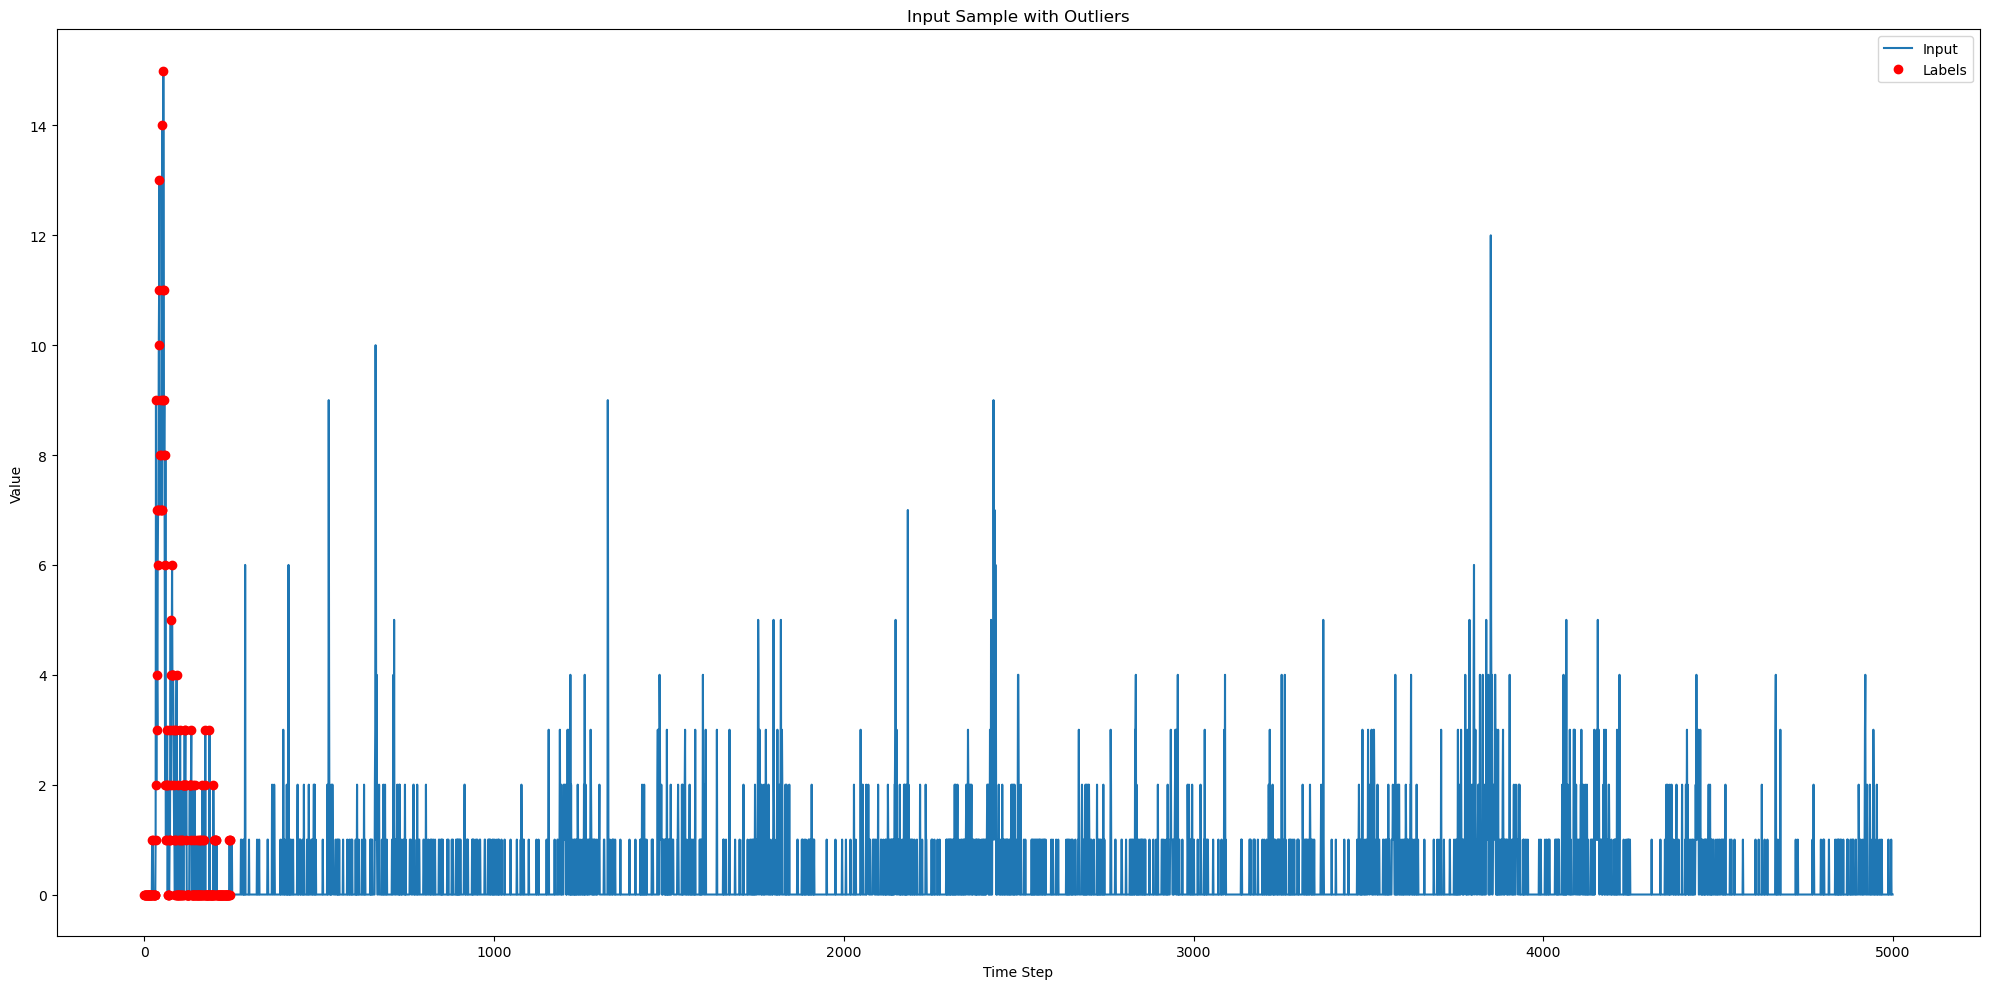

  0%|          | 0/1 [00:00<?, ?it/s]

Classification report


<Figure size 640x480 with 0 Axes>

In [15]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
    
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
    
        std_data = torch.std(sample)
        noise_level = 0.5
        noise = torch.randn_like(sample) * std_data * noise_level
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        noisy_sample = noisy_sample.unsqueeze(-1)
        sample = sample.unsqueeze(-1)
        denoised_sample = model(sample) *2
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()

        # save the fig 
        fig_path = os.path.join(output_dir, "sample_{}.png".format(step))
        plt.savefig(fig_path)
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        print("std_data", std_data)
        threshold = std_data * 2.2

        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()

        #outliers 
        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # calculate the f1 score and auprc score
        f1, auprc, precision, recall = calculate_f1_auprc_score(labels[0], outliers[0])
        print("Precision score:", precision)
        print("Recall score:", recall)
        print("F1 score:", f1)
        print("AUPRC score:", auprc)
        
        # save resutls in output directory
        results = {
            "f1": f1,
            "auprc": auprc
        }
        # save a json file with the results
        results_path = os.path.join(output_dir, "results.json")
        with open(results_path, "w") as f:
            json.dump(results, f)
        
        print("Results saved at", results_path)
        

        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        outlier_indices = np.where(outliers[0] == 1)[0]
        ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # save the fig
        fig_path = os.path.join(output_dir, "outliers_{}.png".format(step))
        plt.savefig(fig_path)
        
                
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # save the fig
        fig_path = os.path.join(output_dir, "labels_{}.png".format(step))
        plt.savefig(fig_path)
        
        # classification report of outliers vs labels focus on the True positive, True negative, False positive and False negative
        print("Classification report")

        
        
    break


In [16]:
def tester(config, model, noise_scheduler, test_dataset): 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    
    # Create dataloader for the test dataset
    test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)
    
    model.eval()
    eval_batch_size = config.eval_batch_size
    
    average_f1 = 0
    average_auprc = 0
    
    results_df = pd.DataFrame(columns=["std_data", "f1", "auprc", "threshold"])

    for step, (sample, timestamps, labels) in enumerate(test_dataloader):
        
        std_data = torch.std(sample)
        
        # after sampling random noise, predict using the model to denoise the sample
        with torch.no_grad():
            timesteps = torch.randint(0, 50 , (eval_batch_size,)).long()
            
            labels = labels.cpu().numpy()
                
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
            print("eval timesteps", timesteps)
        
            std_data = torch.std(sample)
            noise_level = 0.5
            noise = torch.randn_like(sample) * std_data * noise_level
            noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
            
            noisy_sample = noisy_sample.unsqueeze(-1)
            sample = sample.unsqueeze(-1)
            denoised_sample = model(sample) *2
            
            f1 = 0
            auprc = 0
            precision = 0
            recall = 0
            # computing the best threshold for the outliers
            for i in range(len(sample)):              
                best_f1 = 0
                best_threshold = 0
                best_auprc = 0
                best_precision = 0
                best_recall = 0
                
                for threshold in torch.arange(std_data * 0.5, std_data * 2.5, std_data * 0.2):
                    outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
                    
                    f1_temp, auprc_temp, precision_temp, recall_temp = calculate_f1_auprc_score(labels[i], outliers[i])
                    
                    if f1_temp > best_f1:
                        best_f1 = f1_temp
                        best_auprc = auprc_temp
                        best_threshold = threshold
                        best_precision = precision_temp
                        best_recall = recall_temp
                if i ==0:
                    tresh0 = best_threshold   
                print("Best threshold:", best_threshold)
                print("Best F1 score:", best_f1)
                print("Best AUPRC score:", best_auprc)
                print("Best Precision score:", best_precision)
                print("Best Recall score:", best_recall)
                
                f1 += best_f1
                auprc += best_auprc
                precision += best_precision
                recall += best_recall
                
            f1 = f1 / len(sample)
            auprc = auprc / len(sample)
            precision = precision / len(sample)
            recall = recall / len(sample)
            
                
            print("F1 score:", f1 )
            print("AUPRC score:",auprc)
            print("Precision score:", precision)
            print("Recall score:", recall)
            
            threshold = tresh0
            outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
            
            # plot one random sample 
            if step == 0:
                plot_samples(sample[0], noisy_sample[0], denoised_sample[0])
                plot_predictions(sample, denoised_sample, outliers, labels)
            


eval timesteps tensor([866, 361, 790, 296])
Best threshold: tensor(2.3182)
Best F1 score: 0.21809744779582366
Best AUPRC score: 0.08860499911987327
Best Precision score: 0.2554347826086957
Best Recall score: 0.1902834008097166
Best threshold: tensor(1.2143)
Best F1 score: 0.027649769585253458
Best AUPRC score: 0.015509614754992906
Best Precision score: 0.01680672268907563
Best Recall score: 0.07792207792207792
Best threshold: tensor(0.7727)
Best F1 score: 0.12422360248447205
Best AUPRC score: 0.08503343251885967
Best Precision score: 0.12285012285012285
Best Recall score: 0.12562814070351758
Best threshold: tensor(0.7727)
Best F1 score: 0.12195121951219512
Best AUPRC score: 0.08448485079425565
Best Precision score: 0.11848341232227488
Best Recall score: 0.12562814070351758
F1 score: 0.12298050984443606
AUPRC score: 0.06840822429699538
Precision score: 0.12839376011754228
Recall score: 0.1298654400347074


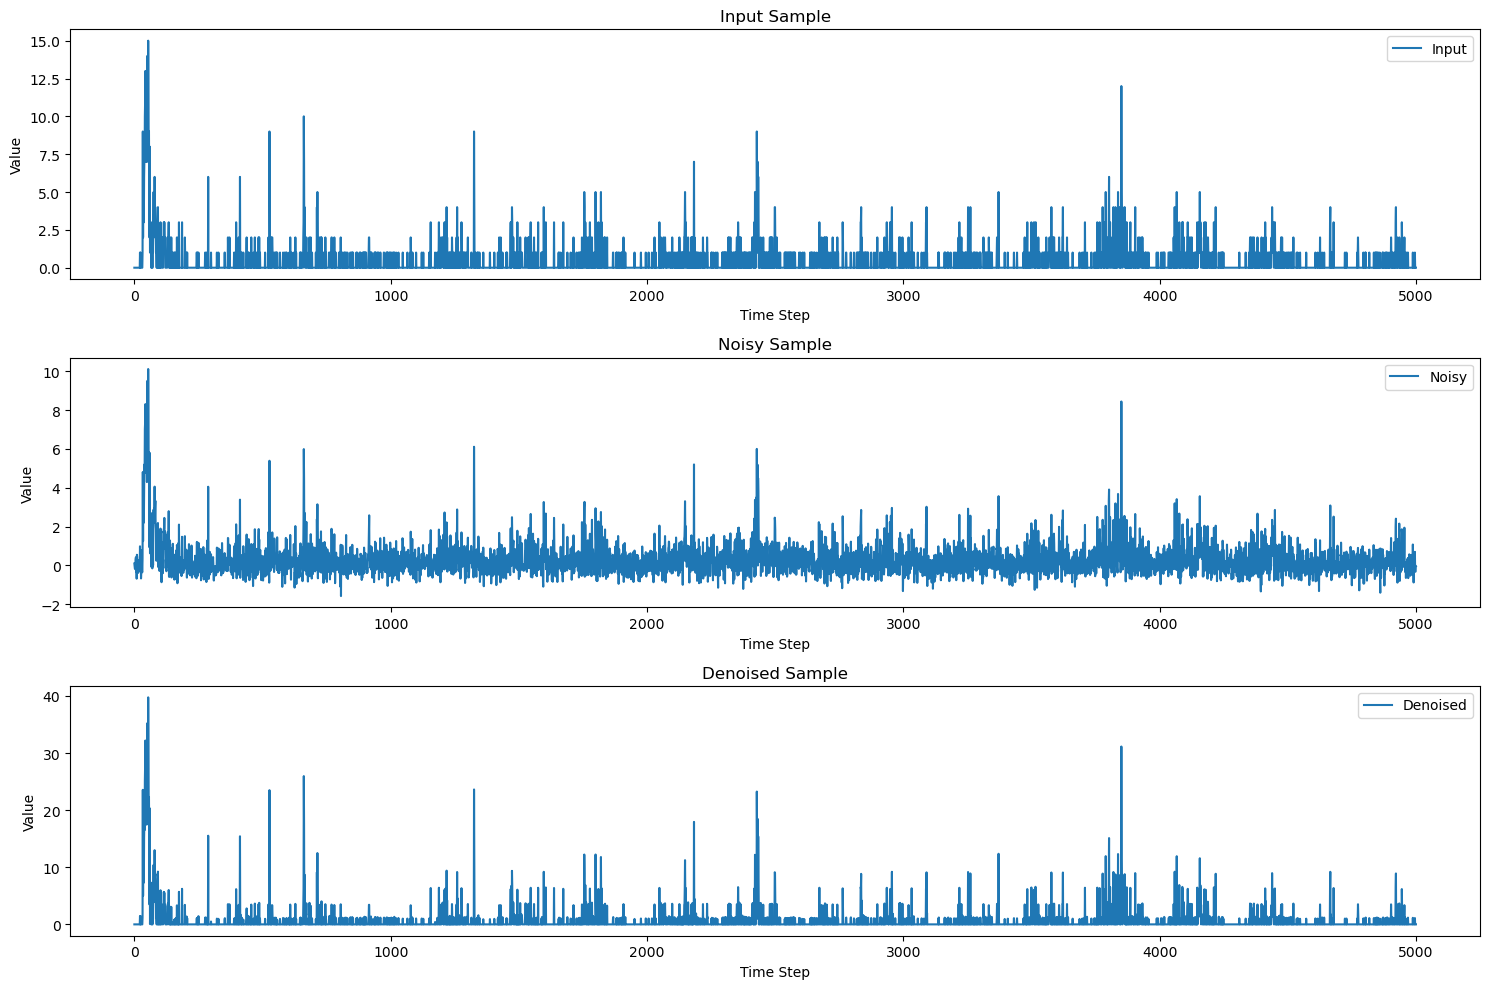

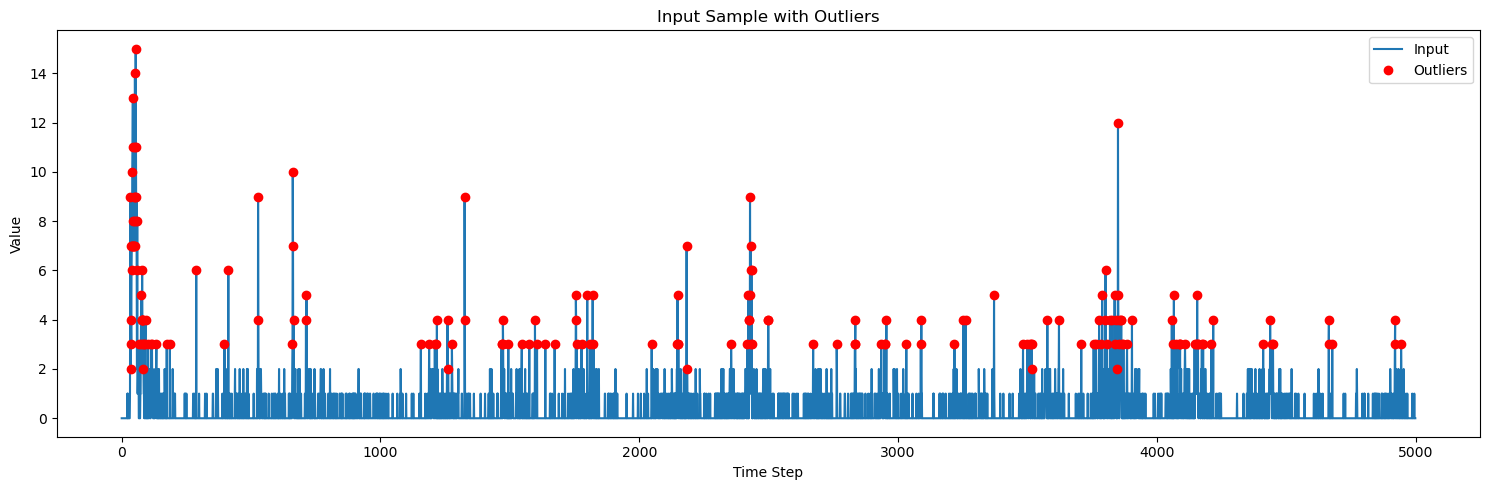

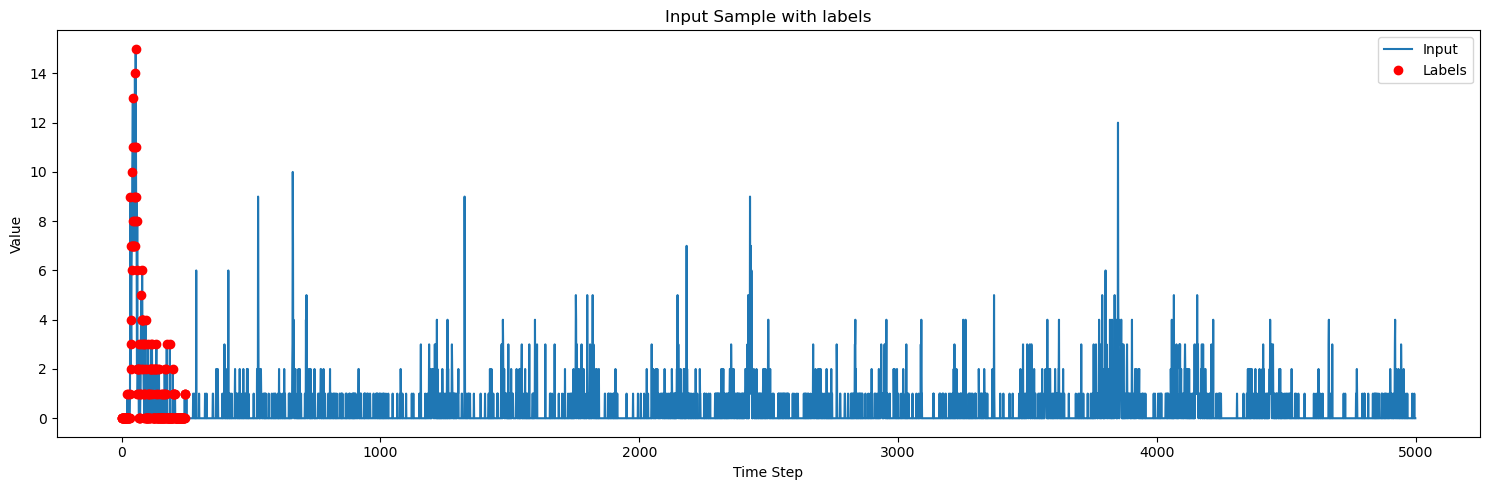

In [17]:
tester(config, model, noise_scheduler, test_dataset)

# Results 

## WSD107

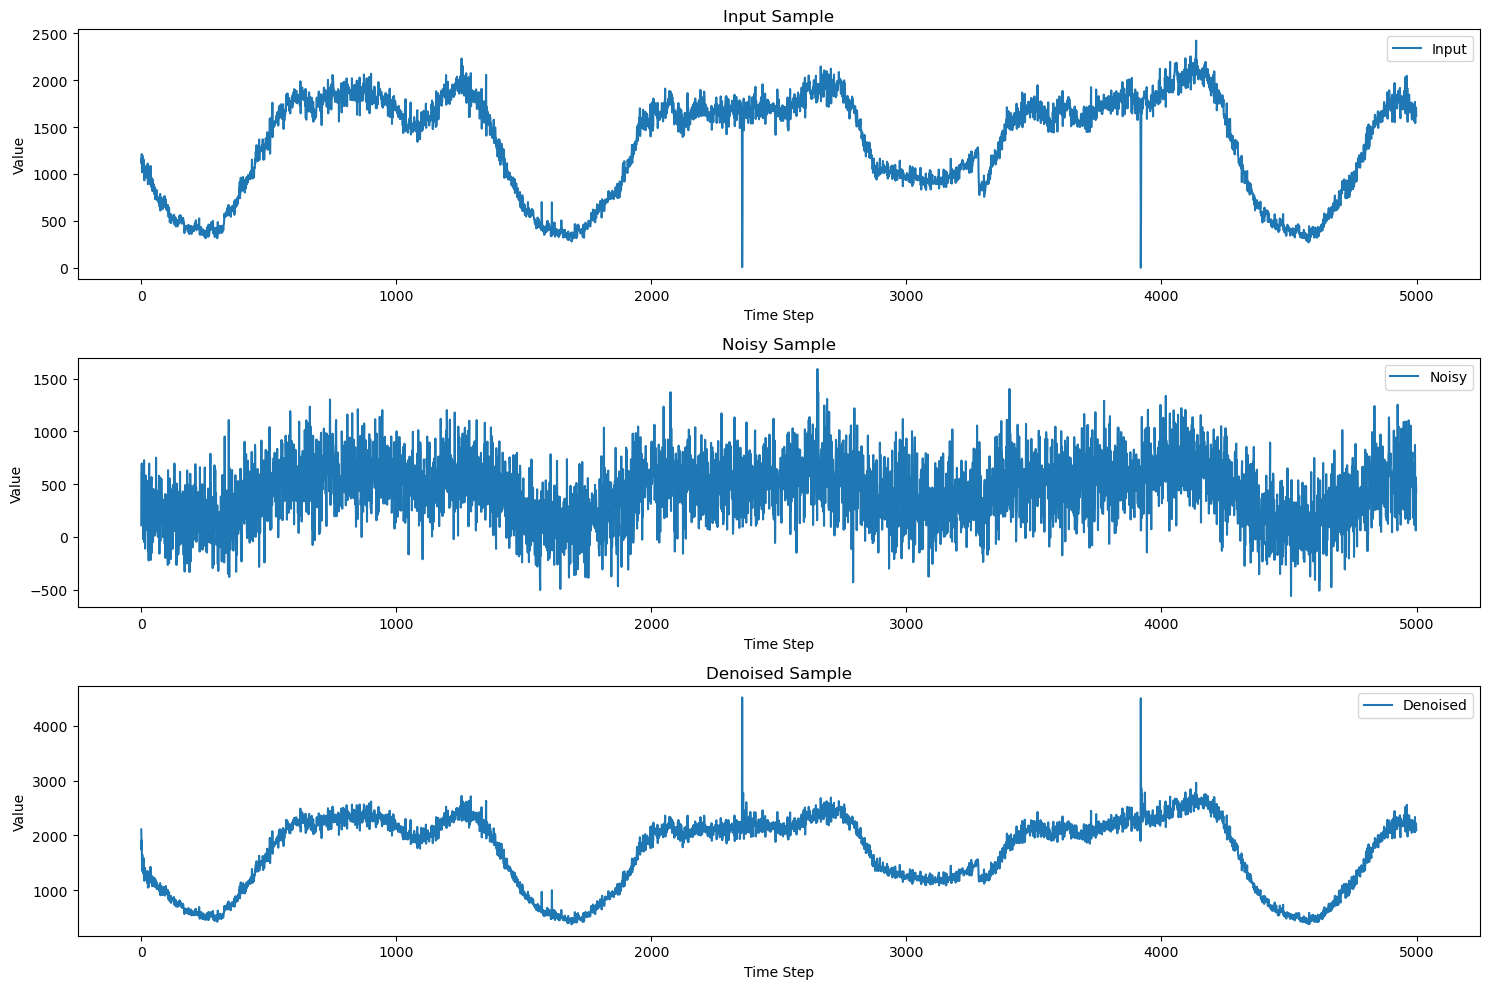
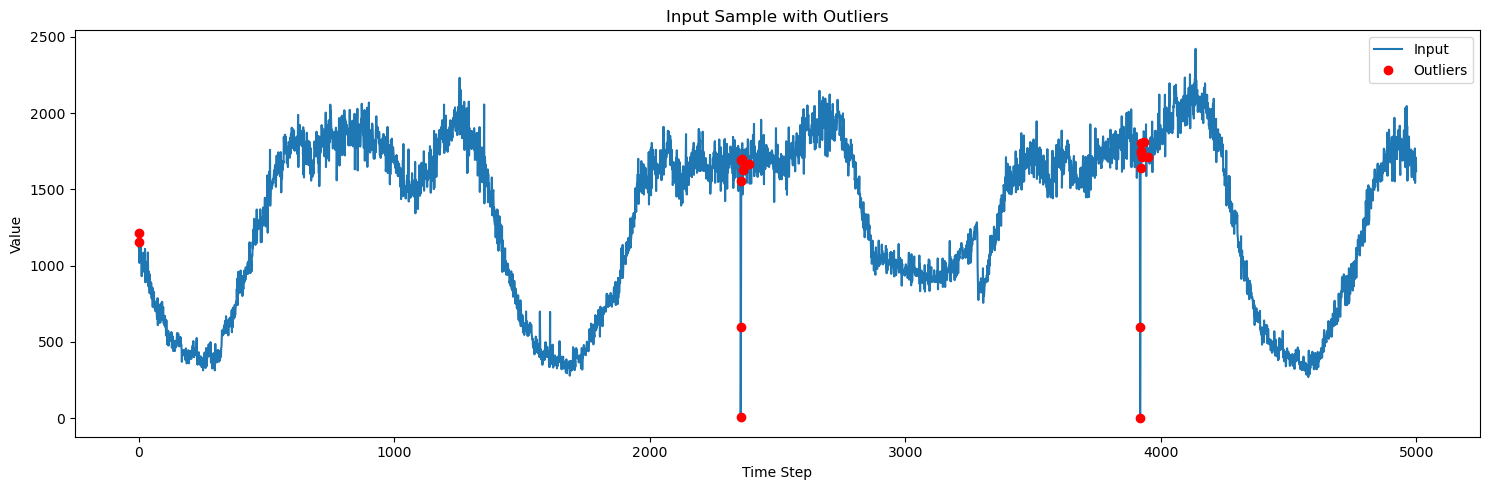

eval timesteps tensor([467, 800, 175,  81, 682, 991, 817, 240, 638, 970, 610, 752, 219, 332,
        400,  91])
Best threshold: tensor(686.2314)
Best F1 score: 0.48148148148148145
Best AUPRC score: 0.25272941176470587
Best Precision score: 0.65
Best Recall score: 0.38235294117647056
Best threshold: tensor(686.2314)
Best F1 score: 0.43478260869565216
Best AUPRC score: 0.2188654064272212
Best Precision score: 0.6521739130434783
Best Recall score: 0.32608695652173914
Best threshold: tensor(686.2314)
Best F1 score: 0.379746835443038
Best AUPRC score: 0.18288944099378884
Best Precision score: 0.6521739130434783
Best Recall score: 0.26785714285714285
Best threshold: tensor(686.2314)
Best F1 score: 0.39473684210526316
Best AUPRC score: 0.20909285714285716
Best Precision score: 0.75
Best Recall score: 0.26785714285714285
Best threshold: tensor(686.2314)
Best F1 score: 0.38571428571428573
Best AUPRC score: 0.18638522727272727
Best Precision score: 0.6136363636363636
Best Recall score: 0.28125
Best threshold: tensor(686.2314)
Best F1 score: 0.37142857142857144
Best AUPRC score: 0.17192865497076024
Best Precision score: 0.5777777777777777
Best Recall score: 0.2736842105263158
Best threshold: tensor(580.6574)
Best F1 score: 0.39
Best AUPRC score: 0.16368120300751882
Best Precision score: 0.37142857142857144
Best Recall score: 0.4105263157894737
Best threshold: tensor(686.2314)
Best F1 score: 0.3950617283950617
Best AUPRC score: 0.1907829903978052
Best Precision score: 0.5925925925925926
Best Recall score: 0.2962962962962963
Best threshold: tensor(791.8055)
Best F1 score: 0.3508771929824561
Best AUPRC score: 0.17153015873015873
Best Precision score: 0.6666666666666666
Best Recall score: 0.23809523809523808
Best threshold: tensor(580.6574)
Best F1 score: 0.4528301886792453
Best AUPRC score: 0.21531428571428568
Best Precision score: 0.48
Best Recall score: 0.42857142857142855
Best threshold: tensor(686.2314)
Best F1 score: 0.3875968992248062
Best AUPRC score: 0.17714391534391535
Best Precision score: 0.5555555555555556
Best Recall score: 0.2976190476190476
Best threshold: tensor(686.2314)
Best F1 score: 0.3902439024390244
Best AUPRC score: 0.1664627450980392
Best Precision score: 0.47058823529411764
Best Recall score: 0.3333333333333333
Best threshold: tensor(580.6574)
Best F1 score: 0.4626865671641791
Best AUPRC score: 0.2214777777777778
Best Precision score: 0.4305555555555556
Best Recall score: 0.5
Best threshold: tensor(791.8055)
Best F1 score: 0.4485981308411215
Best AUPRC score: 0.23817142857142856
Best Precision score: 0.6857142857142857
Best Recall score: 0.3333333333333333
Best threshold: tensor(791.8055)
Best F1 score: 0.49056603773584906
Best AUPRC score: 0.25528809523809526
Best Precision score: 0.6190476190476191
Best Recall score: 0.40625
Best threshold: tensor(791.8055)
Best F1 score: 0.5454545454545454
Best AUPRC score: 0.3549739130434783
Best Precision score: 0.9
Best Recall score: 0.391304347826087
F1 score: 0.4226128636115364
AUPRC score: 0.21104484446841024
Precision score: 0.6042444405847539
Recall score: 0.33965110842519053

# NAB "../datasets/UTS/NAB/Twitter_volume_CVS"

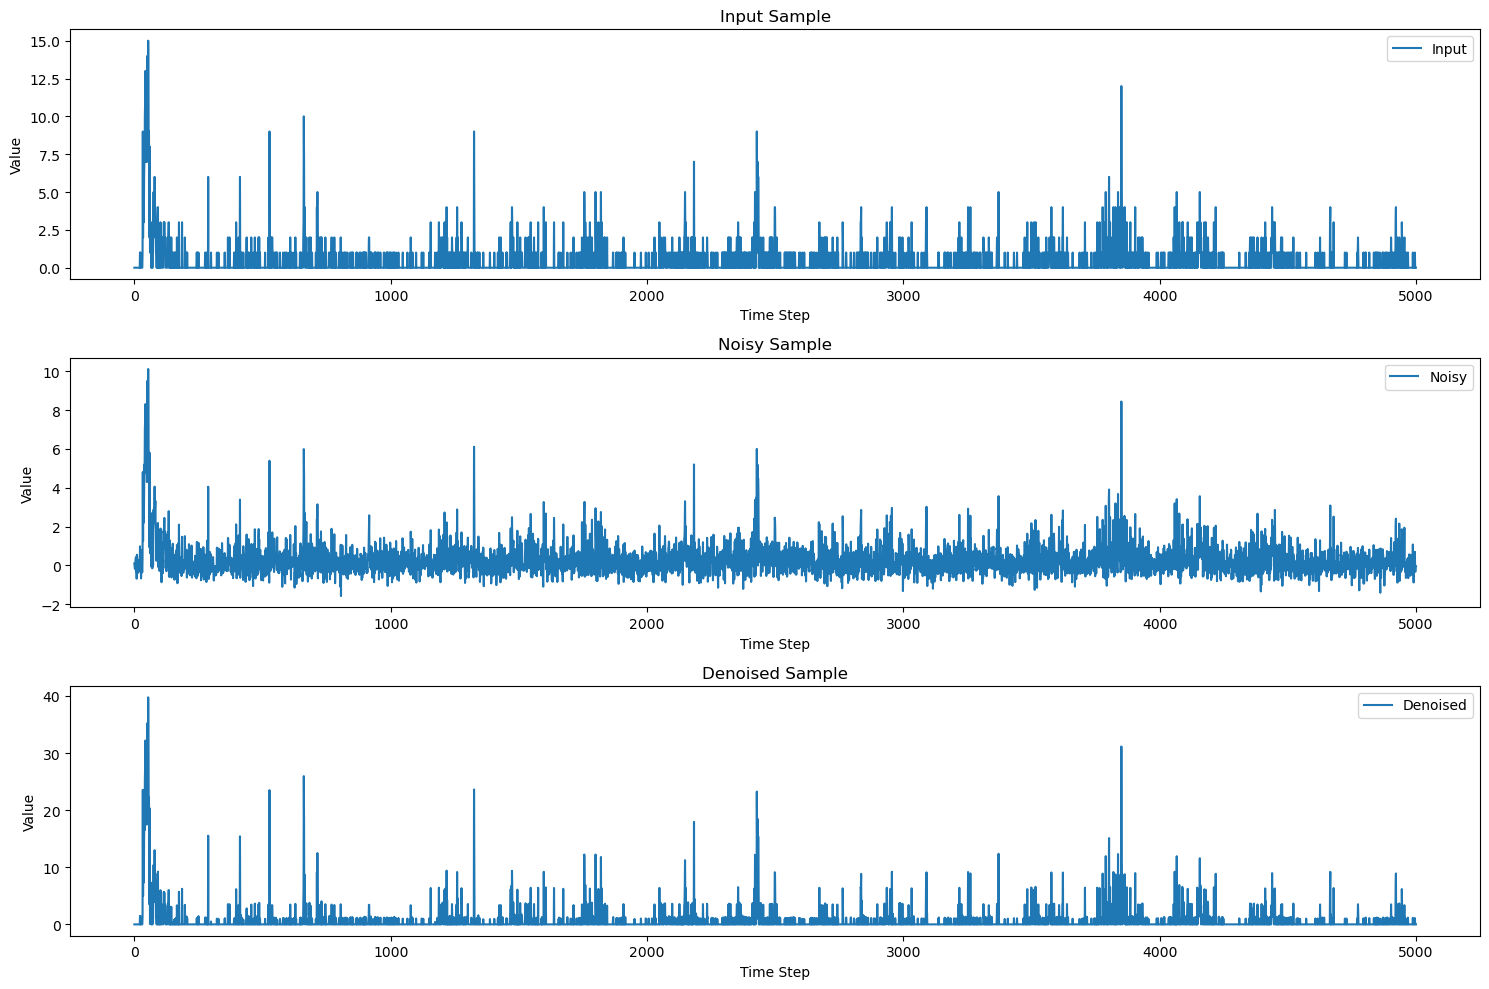
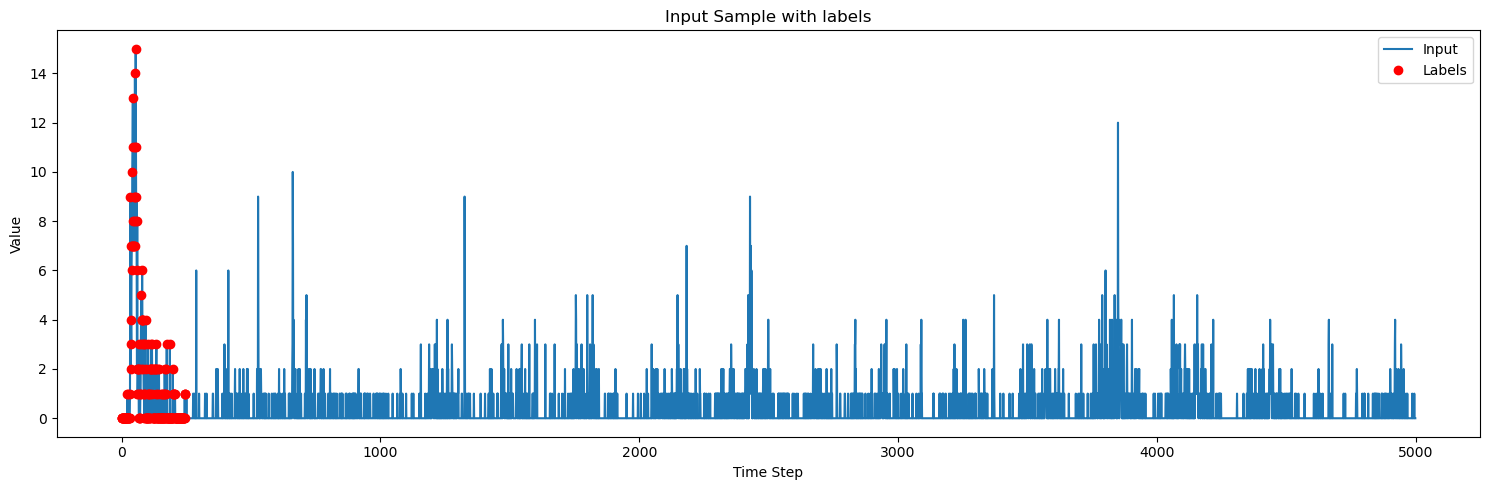
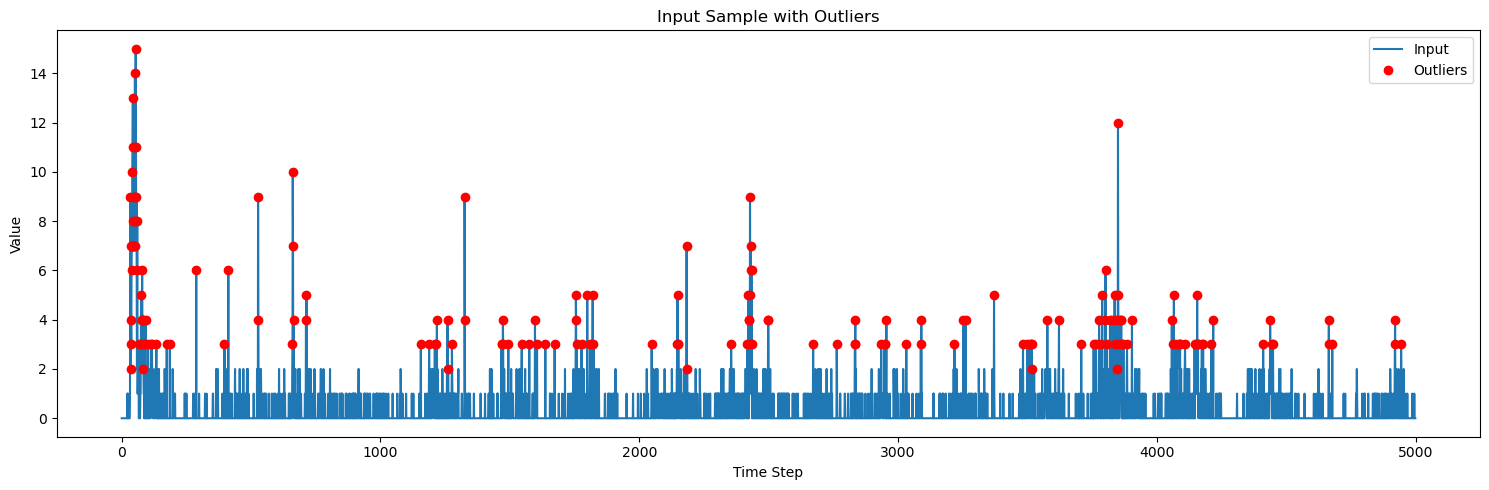

eval timesteps tensor([866, 361, 790, 296])
Best threshold: tensor(2.3182)
Best F1 score: 0.21809744779582366
Best AUPRC score: 0.08860499911987327
Best Precision score: 0.2554347826086957
Best Recall score: 0.1902834008097166
Best threshold: tensor(1.2143)
Best F1 score: 0.027649769585253458
Best AUPRC score: 0.015509614754992906
Best Precision score: 0.01680672268907563
Best Recall score: 0.07792207792207792
Best threshold: tensor(0.7727)
Best F1 score: 0.12422360248447205
Best AUPRC score: 0.08503343251885967
Best Precision score: 0.12285012285012285
Best Recall score: 0.12562814070351758
Best threshold: tensor(0.7727)
Best F1 score: 0.12195121951219512
Best AUPRC score: 0.08448485079425565
Best Precision score: 0.11848341232227488
Best Recall score: 0.12562814070351758
F1 score: 0.12298050984443606
AUPRC score: 0.06840822429699538
Precision score: 0.12839376011754228
Recall score: 0.1298654400347074

# Complete Evaluation

In [35]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [8]:
# plot functions : 
def plot_samples(sample, noisy_sample, denoised_sample):  
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))
    ax = axs[0]
    ax.plot(sample.cpu().numpy())
    ax.set_title("Input Sample")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(["Input"])
    
    ax = axs[1]
    ax.plot(noisy_sample.cpu().numpy())
    ax.set_title("Noisy Sample")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(["Noisy"])
    
    ax = axs[2]
    ax.plot(denoised_sample.cpu().numpy())
    ax.set_title("Denoised Sample")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(["Denoised"])
    
    plt.tight_layout()
    plt.show()

def plot_predictions(sample, denoised_sample, outliers, labels):
    
    # in the same graph visualize the input sample and the predicted outliers and the labels
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(sample[0].cpu().numpy(), label="Input")

    outlier_indices = np.where(outliers[0] == 1)[0]
    ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

    ax.set_title("Input Sample with Outliers")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # in the same graph visualize the input sample and the predicted outliers and the labels
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(sample[0].cpu().numpy(), label="Input")

    label_indices = np.where(labels[0] == True)[0]
    ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
    
    ax.set_title("Input Sample with labels")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [37]:
def trainer(config, model, noise_scheduler, dataset):
    
    dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
    )

    # the training loop
    global_step = 0
    frames = []
    losses = []
    print("Training model...")
    # Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.
        
    for epoch in tqdm(range(config.num_epochs)):
        model.train()
        #progress_bar = tqdm(total=len(dataloader))
        #progress_bar.set_description(f"Epoch {epoch}")
        
        for step, (batch, timestamps, labels) in enumerate(dataloader):
            std_data = torch.std(batch)

            # I want the noise level increasing with epoch
            #noise_level = 0.1 * (epoch+10)/5
            #noise = torch.randn_like(batch) * std_data * noise_level
                    
            noise = torch.randn_like(batch)
            
            timesteps = torch.randint(
                0, noise_scheduler.num_timesteps, (batch.shape[0],)
            ).long()
            
            #print("timesteps", timesteps)
            
            noisy = noise_scheduler.add_noise(batch, noise, timesteps)
            
            noisy = noisy.unsqueeze(-1) 
            # pred noise from the model
            noise_pred = model(noisy)
            
            #print("noise_pred", noise_pred.shape)
            batch = batch.unsqueeze(-1)
            
            loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

            #progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            #progress_bar.set_postfix(**logs)
            global_step += 1
    
    #progress_bar.close()              
    return model, losses

In [38]:
def train_tracker(config, model, dataset):
    # save the model, losses, and all the config parameters in a directory 
    import os
    import json
    import matplotlib.pyplot as plt

    # output dir contains the num epochs 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    # create the directory if it does not exist
    os.makedirs(output_dir, exist_ok=True) 

    # Save the model
    model_path = os.path.join(output_dir, "model.pth")
    torch.save(model.state_dict(), model_path)

    # Save the losses and other parameters in a json file 
    losses_path = os.path.join(output_dir, "losses.json")
    with open(losses_path, "w") as f:
        json.dump(losses, f)
        
    # Save the config 
    config_path = os.path.join(output_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(vars(config), f)

    # Save the losses plot
    # Plot the loss
    plt.plot(losses)
    plt.title("Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    
    # Save the plot before showing it
    losses_plot_path = os.path.join(output_dir, "losses_plot.png")
    plt.savefig(losses_plot_path)
    
    # Display the plot
    plt.show()
        
    """print("Model saved at", model_path)
    print("Losses saved at", losses_path)
    print("Config saved at", config_path)
    print("Loss plot saved at", losses_plot_path)"""

    return model, losses


In [39]:
def tester(config, model, noise_scheduler, test_dataset): 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    
    # Create dataloader for the test dataset
    test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)
    
    model.eval()
    eval_batch_size = config.eval_batch_size
    
    average_f1 = 0
    average_auprc = 0
    
    results_df = pd.DataFrame(columns=["std_data", "f1", "auprc", "threshold"])

    for step, (sample, timestamps, labels) in enumerate(test_dataloader):
        
        std_data = torch.std(sample)
        
        # after sampling random noise, predict using the model to denoise the sample
        with torch.no_grad():
            timesteps = torch.randint(0, 50 , (eval_batch_size,)).long()
                
            #noise_level = 0.5
            #noise = torch.randn_like(sample) * std_data * noise_level
            noise = torch.randn_like(sample) 
            noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
            
            noisy_sample = noisy_sample.unsqueeze(-1)
            sample = sample.unsqueeze(-1)
            denoised_sample = model(noisy_sample)

            labels = labels.cpu().numpy()
                
            best_f1 = 0
            best_threshold = 0
            best_auprc = 0
            # computing the best threshold for the outliers
            for threshold in torch.arange(std_data * 0.5, std_data * 2.5, std_data * 0.2):
                outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
                
                f1 = 0
                auprc = 0
                
                # calculate the f1 score and auprc score
                for i in range(len(outliers)):
                    f1_temp, auprc_temp = calculate_f1_auprc_score(labels[i], outliers[i])
                    f1 += f1_temp
                    auprc += auprc_temp
                
                f1 = f1 / len(outliers)
                auprc = auprc / len(outliers)
         
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
                    best_auprc = auprc
                
            print("F1 score:", best_f1)
            print("AUPRC score:", best_auprc)
            
            # save results in output directory
            results = {
                "std_data": std_data.item(),  # Convert tensor to a scalar
                "f1": best_f1,
                "auprc": best_auprc,
                "threshold": best_threshold  # Convert tensor to a scalar
            }
            
            # Convert the results dictionary to a DataFrame and concatenate with the existing results_df
            results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
            
            # plot one random sample 
            if step == 0:
                plot_samples(sample[0], noisy_sample[0], denoised_sample[0])
                plot_predictions(sample, denoised_sample, outliers, labels)
                
                
    # save as a csvfile 
    results_df.to_csv(os.path.join(output_dir, "results.csv"))
    
    average_f1 += best_f1
    average_auprc += best_auprc
            
    average_f1 = average_f1 / len(test_dataloader)
    average_auprc = average_auprc / len(test_dataloader)
    
    print("Average F1 score:", average_f1)
    print("Average AUPRC score:", average_auprc)
    
    return average_f1, average_auprc


In [40]:
# f1 score and auprc score for 0/1 classification

from sklearn.metrics import f1_score, average_precision_score

# define the function to calculate the f1 score and auprc score
def calculate_f1_auprc_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted',labels=np.unique(y_pred) ) #, labels=np.unique(y_pred) zero_division=np.nan
    auprc = average_precision_score(y_true, y_pred, average='weighted')
    return f1, auprc

## WSD dataset

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

sequence_length = 5000
input_size = 1  # Assuming 1D time series data

base_config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output_WSD",
  "train_batch_size": 16,
  "eval_batch_size": 1,
  "num_epochs": 5,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1000,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}

In [ ]:
import os

data_folder = "../datasets/UTS/WSD"

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
    
        # change datapath in the config
        base_config["data_path"] = data_path
        base_config["output_dir"] = os.path.join("output_WSD", dir)
        
        print(base_config)
        # Create Config object
        config = Config(base_config)
        
        print(config.data_path)

        # Initialize the new TCN model
        model = TCN(
            num_inputs=input_size,  # Number of input channels
            num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
            kernel_size=3,  # Size of the convolution kernel
            dilations=None,  # Dilation sizes
            dilation_reset=None,  # Reset dilation size
            dropout=0.2,  # Dropout rate
            causal=True,  # Causal convolutions for real-time applications
            use_norm='weight_norm',  # Normalization method
            activation='relu',  # Activation function
            kernel_initializer='xavier_uniform',  # Weight initializer
            use_skip_connections=False,  # Skip connections
            input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
            embedding_shapes=None,  # Embedding shapes
            embedding_mode='add',  # Embedding mode ('add' or 'concat')
            use_gate=False,  # Use gated linear unit
            lookahead=0,  # Lookahead for future time steps
            output_projection=None,  # Output projection
            output_activation=None,  # Output activation
        )

        noise_scheduler = NoiseScheduler(
            num_timesteps=config.num_timesteps,
            beta_start=config.beta_start,
            beta_end=config.beta_end,
            beta_schedule=config.beta_schedule
        )

        # Set up dataset and dataloader
        dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)

        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

        #================================================================================================
        # define a pd dataframe to save the results, with the data folder name as the index
        results_df = pd.DataFrame(columns=["data_folder", "average_f1", "average_auprc"])
        results_df.set_index("data_folder", inplace=True)
        
        # train the model and test it
        model, losses = trainer(config, model, noise_scheduler, dataset)
        train_tracker(config, model, dataset)
        average_f1, average_auprc = tester(config, model, noise_scheduler, test_dataset)
        
        # save the results in the dataframe
        results_df.loc[dir] = [average_f1, average_auprc]
        
        print("training and results done for", dir)
        
# save the results in a csv file in outtput directory
results_df.to_csv(os.path.join(config.output_dir, "results.csv"))
